# Moment dynamics with cell division

(c) 2017 Manuel Razo. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT)

---

In [1]:
import pickle
import cloudpickle

# Our numerical workhorses
import numpy as np
import scipy as sp
import pandas as pd

# Import matplotlib stuff for plotting
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl

# Seaborn, useful for graphics
import seaborn as sns

# Import the utils for this project
import chann_cap_utils as chann_cap

# Set PBoC plotting style
chann_cap.set_plotting_style()

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline
%config InlineBackend.figure_format = 'svg'

tmpdir = '../../tmp/'
figdir = '../../fig/moment_dynamics_numeric/'

### $\LaTeX$ macros
$\newcommand{kpon}{k^{(p)}_{\text{on}}}$
$\newcommand{kpoff}{k^{(p)}_{\text{off}}}$
$\newcommand{kron}{k^{(r)}_{\text{on}}}$
$\newcommand{kroff}{k^{(r)}_{\text{off}}}$
$\newcommand{rm}{r _m}$
$\newcommand{gm}{\gamma _m}$
$\newcommand{mm}{\left\langle m \right\rangle}$
$\newcommand{ee}[1]{\left\langle #1 \right\rangle}$
$\newcommand{bb}[1]{\mathbf{#1}}$

## Distribution moment dynamics with cell division 

As first discussed by Jones et al. and then further expanded by [Peterson et al.](http://www.pnas.org/content/112/52/15886) the effect of having multiple gene copy numbers due to genome replication during the cell cycle has an important effect on gene expression noise. As the genome is replicated the cells spend part of their cell cycle with > 1 copy of the gene. The number of copies depends on the growth rate and on the gene position relative to the replication origin.

For our experimental setup we know from Jones et al. that our cells spend 2/3 of the cell cycle with 2 copies of the reporter gene and 1/3 with 1 copy. We previously inferred the parameters $\kpon$, $\kpoff$, and $r_m$ assuming that at both stages the mRNA reached steady state with $r_m$ as production rate for 1 gene copy and $2 r_m$ for two copies. The objective of this notebook is to explore the dynamical consequences of these gene copy number variations at the level of the mRNA and protein distribution moments.

The first thing we need to establish are the dynamics for the mRNA. The cell cycle time $t_d \approx 60$ min establishes the period of the cell cycle. For a time $0 < t_s < t_d$ cells have 1 copy of the gene (i.e. mRNA production rate $r_m$) and for the rest of the cycle the cells have 2 copies of the gene (i.e. mRNA production rate of $2 r_m$).

Therefore for our simulations we will initialize the moments at the steady state values for the single promoter, run the simulation with those parameters for time 0 to $t_s$ and then change the parameters for the rest of the simulation until reaching time $t_d$.

### Cell division

After cells reach time $t_d$ the content of the cells is assumed to divide as they divide too. To account for this division we will assume that the mean mRNA (and later on protein) count are halved. Given the dependence of higher moments on the first moment we will "re-initialize" the value of the other moments assuming the values that one would obtain if this halved mean mRNA count was the steady state value. 

In other words assume that the mean mRNA count at time $t_d$ is given by $\ee{m(t_d)}$. After this time we reset the initial condition for the simulation with one promoter to be $\ee{m(t=0)} = {\ee{m(t_d)} \over 2}$. By fixing the first moment values higher moments of the mRNA distirbution $\ee{m^x}$ will be computed by finding what the steady state value would be given the value of the first moment. Note that this will not strictly give the same values as just computing the steady state value of the moments. If the initial condition $\ee{m(t=0)}$ is not the same as steady state condition $\ee{m}_{ss}$ the values that the other moments will also differ from the steady state values.

The reason for this convoluted assumption is that dividing the first moment in half after cell division makes sense, but it is not clear that the same assumption applies for higher moments of the distribution. To gain intuition about this assume that the mRNA distribution is binomial with mean value $\ee{m(t_d)} = N p$. Dividing this by half for the initial condition is easy since we would have $\ee{m(t=0)} = {N p \over 2}$. The second moment before the cell division would be of the form $\ee{m^2(t_d)} = Np - Np^2 + N^2p^2$. Therefore dividing this value by two for the initial condition of the next cell cycle doesn't translate to the second moment one would expect for a binomial distribution with mean ${Np \over 2}$.

## Defining mRNA dynamics 

We will now define functions to compute the first 3 mRNA distribution moments. The PDEs that define these moments are given by
\begin{align}
% zeroth moment
{d \over dt} \ee{\bb{m}^0} &= \mathbf{K}_m \left\langle \mathbf{m}^0 \right\rangle, \\
%first moment
{d \over dt}\ee{\bb{m}^1} &= 
\left( \mathbf{K}_m - \mathbf{\Gamma}_m  \right)\ee{\bb{m}^1}
             + \mathbf{R}_m \left\langle \mathbf{m}^0 \right\rangle, \\
% second moment
{d\ee{\bb{m}^2} \over dt} &= \left( \mathbf{K}^u_m - 2 \mathbf{\Gamma}^u_n \right) 
             \left\langle \mathbf{m}^2 \right\rangle
             + \left( 2 \mathbf{R}^u_m + \mathbf{\Gamma}^u_m \right)
             \left\langle \mathbf{m}^1 \right\rangle
             + \mathbf{R}^u_m
             \left\langle \mathbf{m}^0 \right\rangle,  \\
% third moment
{d\ee{\bb{m}^3} \over dt} &= \left( \mathbf{K}_m - 3 \mathbf{\Gamma}_n \right) 
             \left\langle \mathbf{m}^3 \right\rangle
             + \left( 3 \mathbf{R}_m + 3 \mathbf{\Gamma}_m \right)
             \left\langle \mathbf{m}^2 \right\rangle
             + \left( 3 \mathbf{R}_m - \mathbf{\Gamma}_m \right)
             \left\langle \mathbf{m}^1 \right\rangle
             + \mathbf{R}_m
             \left\langle \mathbf{m}^0 \right\rangle.
\end{align}

From these equations it is clear that the second and third moment depend on the value of the first (and zeroth) moment. For the first function `dmdt` the equations for the first and zeroth moment will be included in the numerical integration. For the second function `dmdt_init` the values for $\left\langle \mathbf{m}^0 \right\rangle$ and $\left\langle \mathbf{m}^1 \right\rangle$ are assumed to be fixed and the rest of the moments are computed accordingly.

In [2]:
def dmdt(m, t, Kmat, Rmat, Gmat):
    '''
    function to integrate dm / dt using scipy.integrate.odeint
    Parameters
    ----------
    m : array-like.
        Array containing the zeroth, first, second and third moment 
        of the states of the promoter.
        Unregulated
        m[0] = m0_P (RNAP bound)
        m[1] = m0_E (Empty promoter)
        m[2] = m1_P (RNAP bound)
        m[3] = m1_P (Empty promoter)
        m[4] = m2_P (RNAP bound)
        m[5] = m2_P (Empty promoter)
        m[6] = m3_P (RNAP bound)
        m[7] = m3_P (Empty promoter)
        ---------
        Regulated:
        m[0] = m0_P (RNAP bound)
        m[1] = m0_E (Empty promoter)
        m[2] = m0_R (Repressor bound) 
        m[3] = m1_P (RNAP bound)
        m[4] = m1_E (Empty promoter)
        m[5] = m1_R (Repressor bound) 
        m[6] = m2_P (RNAP bound)
        m[7] = m2_E (Empty promoter)
        m[8] = m2_R (Repressor bound) 
        m[9] = m3_P (RNAP bound)
        m[10] = m3_E (Empty promoter)
        m[11] = m3_R (Repressor bound) 
    t : array-like.
        Time array
    Kmat : array-like.
        Matrix containing the transition rates between the promoter states.
    Rmat : array-like.
        Matrix containing the production rate at each of the states.
    Gmat : array-like.
        Matrix containing the degradation rate at each of the states.   
        
    Returns
    -------
    numerical integration of the differential equations
    '''
    # Obtain the zeroth and first moment based on the size 
    # of the Kmat matrix
    if Kmat.shape[0] == 2:
        m0 = m[0:2]
        m1 = m[2:4]
        m2 = m[4:6]
        m3 = m[6::]
    elif Kmat.shape[0] == 3:
        m0 = m[0:3]
        m1= m[3:6]
        m2= m[6:9]
        m3= m[9::]
    
    # Compute the moment equations for the:
    # Zeroth moment
    dm0dt_eq = np.dot(Kmat, m0)
    # First moment
    dm1dt_eq = np.dot((Kmat - Gmat), m1) + np.dot(Rmat, m0)
    # Second moment
    dm2dt_eq = np.dot((Kmat - 2 * Gmat), m2) + np.dot((2 * Rmat + Gmat), m1) +\
                np.dot(Rmat, m0)
    # Third moment
    dm3dt_eq = np.dot((Kmat - 3 * Gmat), m3) +\
                np.dot((3 * Rmat + 3 * Gmat), m2) +\
                np.dot((3 * Rmat - Gmat), m1) +\
                np.dot(Rmat, m0)
    
    return np.append(dm0dt_eq, 
                     np.append(dm1dt_eq, 
                               np.append(dm2dt_eq, dm3dt_eq)))

def dmdt_init(m, t, m_fix, Kmat, Rmat, Gmat):
    '''
    function to integrate dm / dt using scipy.integrate.odeint
    This funciton assumes that the zeroth and first moment are fixed
    and computes the corresponding second and third moments accordingly.
    Parameters
    ----------
    m : array-like.
        Array containing the second and third moment 
        of the states of the promoter.
        Unregulated
        m[0] = m2_P (RNAP bound)
        m[1] = m2_E (Empty promoter)
        m[2] = m3_P (RNAP bound)
        m[3] = m3_E (Empty promoter)
        ---------
        Regulated: 
        m[0] = m2_P (RNAP bound)
        m[1] = m2_E (Empty promoter)
        m[2] = m2_R (Repressor bound) 
        m[3] = m3_P (RNAP bound)
        m[4] = m3_E (Empty promoter)
        m[5] = m3_R (Repressor bound)    
    t : array-like.
        Time array
    m_fix : array-like.
        Array containing the zerot and first moment 
        of the states of the promoter that will remain fixed.
        Unregulated
        m_fix[0] = m0_P (RNAP bound)
        m_fix[1] = m0_E (Empty promoter)
        m_fix[2] = m1_P (RNAP bound)
        m_fix[3] = m1_E (Empty promoter)
    ---------
    Regulated:
        m_fix[0] = m0_P (RNAP bound)
        m_fix[1] = m0_E (Empty promoter)
        m_fix[2] = m0_R (Repressor bound) 
        m_fix[3] = m1_P (RNAP bound)
        m_fix[4] = m1_E (Empty promoter)
        m_fix[5] = m1_R (Repressor bound)
    Kmat : array-like.
        Matrix containing the transition rates between the promoter states.
    Rmat : array-like.
        Matrix containing the production rate at each of the states.
    Gmat : array-like.
        Matrix containing the degradation rate at each of the states.   
        
    Returns
    -------
    2nd and 3rd moment dynamics given fixed 0th and 1st moment
    '''
    # Obtain the zeroth and first moment based on the size 
    # of the Kmat matrix
    if Kmat.shape[0] == 2:
        m0 = m_fix[0:2]
        m1 = m_fix[2::]
        m2 = m[0:2]
        m3 = m[2::]
    elif Kmat.shape[0] == 3:
        m0 = m_fix[0:3]
        m1= m_fix[3::]
        m2= m[0:3]
        m3= m[3::]
    
    # Compute the moment equations for the:
    # Second moment
    dm2dt_eq = np.dot((Kmat - 2 * Gmat), m2) + np.dot((2 * Rmat + Gmat), m1) +\
                np.dot(Rmat, m0)
    # Third moment
    dm3dt_eq = np.dot((Kmat - 3 * Gmat), m3) +\
                np.dot((3 * Rmat + 3 * Gmat), m2) +\
                np.dot((3 * Rmat - Gmat), m1) +\
                np.dot(Rmat, m0)
    
    return np.append(dm2dt_eq, dm3dt_eq)

### Defining function to compute moments over severall cell cycles

Having defined the functions to integrate the moment ODEs let's now define a function that given a time `t_single` that cells spend with one promoter copy and a time `t_double` that cells spend with two copies integrates the moments over several cell cycles.

In [3]:
def dmdt_cycles(m_init, t_single, t_double, n_cycles, 
                Kmat, Rmat, Gmat, n_steps=1000, t_ss=10000,
                states=['P', 'E']):
    '''
    Function that integrates the mRNA moments over several cell cycles.
    Parameters
    ----------
    m : array-like.
        Array containing the zeroth, first, second and third moment 
        of the states of the promoter.
        Unregulated
        m[0] = m0_P (RNAP bound)
        m[1] = m0_E (Empty promoter)
        m[2] = m1_P (RNAP bound)
        m[3] = m1_E (Empty promoter)
        m[4] = m2_P (RNAP bound)
        m[5] = m2_E (Empty promoter)
        m[6] = m3_P (RNAP bound)
        m[7] = m3_E (Empty promoter)
        ---------
        Regulated:
        m[0] = m0_P (RNAP bound)
        m[1] = m0_E (Empty promoter)
        m[2] = m0_R (Repressor bound) 
        m[3] = m1_P (RNAP bound)
        m[4] = m1_E (Empty promoter)
        m[5] = m1_R (Repressor bound) 
        m[6] = m2_P (RNAP bound)
        m[7] = m2_E (Empty promoter)
        m[8] = m2_R (Repressor bound) 
        m[9] = m3_P (RNAP bound)
        m[10] = m3_E (Empty promoter)
        m[11] = m3_R (Repressor bound)
    t_single : float.
        Time [in 1/mRNA degradation rate units] that cells spend 
        with a single promoter copy
    t_double : float.
        Time [in 1/mRNA degradation rate units] that cells spend 
        with a two promoter copies.
    n_cycles : int.
        Number of cell cycles to integrate for. A cell cycle is defined
        as t_single + t_double.
    Kmat : array-like.
        Matrix containing the transition rates between the promoter states.
    Rmat : array-like.
        Matrix containing the production rate at each of the states.
    Gmat : array-like.
        Matrix containing the degradation rate at each of the states.
    n_steps : int. Default = 300.
        Number of steps to use for the numerical integration.
    t_ss : float.
        Time to integrate for after cell division to compute the steady
        state value of higher moments.

    Returns
    -------
    mRNA moment dynamics over cell cycles
    '''
    # Initialize names for moments in data frame
    names = ['m' + str(mom) + '_' + st for mom in range(4) for st in states]
    
    # Initialize data frame
    df = pd.DataFrame(columns=['time', 'state', 'cycle'] + names)
    
    # Initilaize global time
    t_sim = 0
    # Loop through cycles
    for cyc in range(n_cycles):
        # == Single promoter == #
        # Define time array
        t = np.linspace(0, t_single, n_steps)

        # Integrate moment equations
        m = sp.integrate.odeint(dmdt, m_init, t, 
                             args=(Kmat, Rmat, Gmat))

        # Generate data frame
        df_m = pd.DataFrame(m, columns=names)
        # Append time, state and cycle
        df_m = df_m.assign(time=t + t_sim)
        df_m = df_m.assign(state=['single'] * m.shape[0])
        df_m = df_m.assign(cycle=[cyc] * m.shape[0])
        
        # Append results to global data frame
        df = df.append(df_m, ignore_index=True, sort=False)
        
        # Update global time
        t_sim = t_sim + t[-1]
        
        # == Two promoters == #
        
        # Define initial conditions as last point of single promoter state
        m_init = m[-1, :]
        
        # Define time array
        t = np.linspace(0, t_double, n_steps)

        # Integrate moment equations
        m = sp.integrate.odeint(dmdt, m_init, t, 
                             args=(Kmat, 2 * Rmat, Gmat))

        # Generate data frame
        df_m = pd.DataFrame(m, columns=names)
        # Append time, state and cycle
        df_m = df_m.assign(time=t + t_sim)
        df_m = df_m.assign(state=['double'] * m.shape[0])
        df_m = df_m.assign(cycle=[cyc] * m.shape[0])
        
        # Append results to global data frame
        df = df.append(df_m, ignore_index=True, sort=False)
        
        # Update global time
        t_sim = t_sim + t[-1]
        
        # == Cell division == #
        
        # Define time array
        t = np.linspace(0, t_ss, n_steps)
        
        # Define initial conditions as last point of single promoter state
        m_fix = m[-1, 0:(Kmat.shape[0]*2)]
        # Divide mean mRNA by half
        m_fix[(Kmat.shape[0])::] = m_fix[(Kmat.shape[0])::] / 2
        # Set initial condiitons for higher moments.
        m_init = m[-1, (Kmat.shape[0]*2)::]
        
        # Define initial conditions for moments after cell division
        m = sp.integrate.odeint(dmdt_init, m_init, t, 
                             args=(m_fix, Kmat, Rmat, Gmat))
        
        m_init = np.append(m_fix, m[-1, :])
        
    return df

# Two-state promoter
Having defined these functions let's first test them with the two-state unregulated promoter.

Let's define the necessary parameters.

In [4]:
# Define mRNA rate
# http://bionumbers.hms.harvard.edu/bionumber.aspx?id=105717&ver=3&trm=lacZ%20mRNA%20lifetime&org=
gm = 1 / (3 * 60)

# Load the flat-chain
with open('../../data/mcmc/lacUV5_constitutive_mRNA_double.pkl', 'rb') as file:
    unpickler = pickle.Unpickler(file)
    gauss_flatchain = unpickler.load()
    gauss_flatlnprobability = unpickler.load()

# Generate a Pandas Data Frame with the mcmc chain
index = ['kp_on', 'kp_off', 'rm']

# Generate a data frame out of the MCMC chains
df_mcmc = pd.DataFrame(gauss_flatchain, columns=index)

# rerbsine the index with the new entries
index = df_mcmc.columns

# map value of the parameters
max_idx = np.argmax(gauss_flatlnprobability, axis=0)
kp_on, kp_off, rm = df_mcmc.iloc[max_idx, :] * gm

Now we will define the state transition matrix $\mathbf{K}$, the mRNA production matrix $\mathbf{R}_m$ and the mRNA degradation matrix $\mathbf{\Gamma}_m$.

In [5]:
# Define the rate constant matrix
Kmat_unreg = np.array([[-kp_off, kp_on], 
                       [kp_off, -kp_on]])
# Define the production matrix
Rmat_unreg = np.array([[rm, 0], 
                       [0, 0]])
# Define the degradation matrix
Gmat_unreg = np.array([[gm, 0],
                       [0, gm]])

Having defined this let's integrate the equations for a long time to obtain the initial condition.

In [6]:
# Define time on which to perform integration
t = np.linspace(0, 100 * 60, 301)

# Define initial conditions
m0_init = [0.5, 0.5]
m1_init = [0, 0]
m2_init = [0, 0]
m3_init = [0, 0]

# Numerically integrate equations
m_init = sp.integrate.odeint(dmdt, m0_init + m1_init + m2_init + m3_init, t, 
                             args=(Kmat_unreg, Rmat_unreg, Gmat_unreg))

m_init = m_init[-1, :]

Let's now define the necesary inputs and run the numerical integration for several cell cycles.

In [7]:
# Define time for single-promoter state
t_single = 60 * 1 / 3 * 60 # sec
# Define time for two-promoter state
t_double = 60 * 2 / 3 * 60 # sec
# Define number of cell cycles
n_cycles = 3

# Integrate moment equations
df = dmdt_cycles(m_init, t_single, t_double, n_cycles, 
                 Kmat_unreg, Rmat_unreg, Gmat_unreg)

Now let's plot the first moment $\pm$ standard deviation.

In [8]:
# Extract index for first and second moment
first_mom_names = [x for x in df.columns if 'm1' in x]
second_mom_names = [x for x in df.columns if 'm2' in x]

# Compute the mean mRNA copy number
m_mean = df.loc[:, first_mom_names].sum(axis=1)

# Compute the variance
m_second = df.loc[:, second_mom_names].sum(axis=1)
m_var = (m_second - m_mean**2)

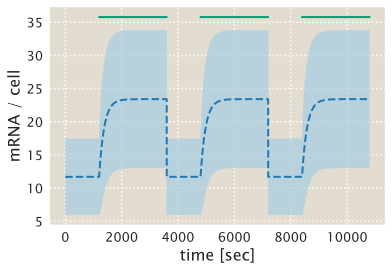

In [38]:
# Define color
colors = np.flip(sns.color_palette('Paired', n_colors=2), axis=0)

# Plot mean mRNA as solid line
plt.plot(df.time, m_mean, label=r'$\left\langle m \right\rangle$', 
         color=colors[0], linestyle='--')
# Plot +- standard deviation
plt.fill_between(df.time, m_mean - np.sqrt(m_var), m_mean + np.sqrt(m_var),
                 alpha=0.7, color=colors[1])

# Group data frame by cell cycle
df_group = df.groupby('cycle')
# Loop through cycles
for i, (group, data) in enumerate(df_group):
    # Find index for two-promoter state
    idx = data.state == 'double'
    # Indicate states with two promoters
    plt.plot(data.loc[idx, 'time'], 
             np.array([(m_mean + np.sqrt(m_var)).max() + 2] * len(data))[idx],
             color='g')

# Label plot
plt.xlabel('time [sec]')
plt.ylabel('mRNA / cell')

## Defining Protein dynamics 

Having worked out the mRNA dynamics let's extend this approach to the protein dynamics. First let's list the ODEs for the moments.

### Protein moments (and cross correlations)
\begin{align}
% first moment
{d \ee{\bb{p}^1}\over dt} &=
\left( \mathbf{K} - \mathbf{\Gamma}_p  \right) \ee{\bb{p}^1}
+ \mathbf{R}_p \left\langle \mathbf{m} \right\rangle.\\
% <mp>
{d \ee{\bb{mp}}\over dt} &=
\left( \mathbf{K} - \mathbf{\Gamma}_m -  \mathbf{\Gamma}_p  \right)
\left\langle \mathbf{mp} \right\rangle 
+ \mathbf{R}_m \left\langle \mathbf{p} \right\rangle
+ \mathbf{R}_p \left\langle \mathbf{m}^2 \right\rangle \\
% second moment
{d \ee{\bb{p}^2}\over dt} &=
\left( \mathbf{K} - 2 \mathbf{\Gamma}_p \right) 
\left\langle \mathbf{p}^2 \right\rangle
+ \mathbf{\Gamma}_p \left\langle \mathbf{p} \right\rangle
+ \mathbf{R}_p \mm
+ 2 \mathbf{R}_p \left\langle \mathbf{mp} \right\rangle \\
% <m^2p>
{d \ee{\bb{m}^2\bb{p}}\over dt} &=   
\left( \bb{K} - 2 \bb{\Gamma}_m - \bb{\Gamma}_p \right) 
\ee{\bb{m}^2\bb{p}} +
\bb{R}_m \ee{\bb{p}} +
\left( \bb{R}_m + \bb{\Gamma}_m \right) \ee{\bb{mp}} +
\bb{R}_p \ee{\bb{m}^3}.\\
% <mp^2>
{d \ee{\bb{m}\bb{p}^2}\over dt} &=   
\left( \bb{K} - \bb{\Gamma}_m - 2 \bb{\Gamma}_p \right)
\ee{\bb{mp}^2} +
\bb{R}_m \ee{\bb{p}^2} +
2 \bb{R}_p \ee{\bb{m}^2\bb{p}} +
\bb{R}_p \ee{\bb{m}^2} +
\bb{\Gamma}_p \ee{\bb{mp}}.\\
% third moment
{d \ee{\bb{p}^3}\over dt} &=
\left( \bb{K} - 3 \bb{\Gamma}_p \right) \ee{\bb{p}^3} +
3 \bb{\Gamma}_p \ee{\bb{p}^2} -
\bb{\Gamma}_p \ee{\bb{p}} +
3 \bb{R}_p \ee{\bb{mp}^2} +
3 \bb{R}_p \ee{\bb{mp}} +
\bb{R}_p \ee{\bb{m}}.
\end{align}

Let's now implemenet these equations into a function `dpdt`. And just as with the mRNA case we will define a function to compute the initial conditions after cell division `dpdt_init`.

In [51]:
def dpdt(mp, t, Kmat, Rm, Gm, Rp, Gp):
    '''
    function to integrate all mRNA and protein moment dynamics
    using scipy.integrate.odeint
    Parameters
    ----------
    m : array-like.
        Array containing all moments (mRNA, protein and cross correlations) 
        Unregulated
        mp[0] = m0_P (RNAP bound)
        mp[1] = m0_E (Empty promoter)
        mp[2] = m1_P (RNAP bound)
        mp[3] = m1_P (Empty promoter)
        mp[4] = m2_P (RNAP bound)
        mp[5] = m2_P (Empty promoter)
        mp[6] = m3_P (RNAP bound)
        mp[7] = m3_P (Empty promoter)
        mp[8] = p1_P (RNAP bound)
        mp[9] = p1_P (Empty promoter)
        mp[10] = mp_P (RNAP bound)
        mp[11] = mp_P (Empty promoter)
        mp[12] = p2_P (RNAP bound)
        mp[13] = p2_P (Empty promoter)
        mp[14] = m2p_P (RNAP bound)
        mp[15] = m2p_P (Empty promoter)
        mp[16] = mp2_P (RNAP bound)
        mp[17] = mp2_P (Empty promoter)
        mp[18] = p3_P (RNAP bound)
        mp[19] = p3_P (Empty promoter)
        ---------
        Regulated:
        mp[0] = m0_P (RNAP bound)
        mp[1] = m0_E (Empty promoter)
        mp[2] = m0_R (Repressor bound) 
        mp[3] = m1_P (RNAP bound)
        mp[4] = m1_E (Empty promoter)
        mp[5] = m1_R (Repressor bound) 
        mp[6] = m2_P (RNAP bound)
        mp[7] = m2_E (Empty promoter)
        mp[8] = m2_R (Repressor bound) 
        mp[9] = m3_P (RNAP bound)
        mp[10] = m3_E (Empty promoter)
        mp[11] = m3_R (Repressor bound) 
        mp[12] = p1_P (RNAP bound)
        mp[13] = p1_E (Empty promoter)
        mp[14] = p1_R (Repressor bound) 
        mp[15] = mp_P (RNAP bound)
        mp[16] = mp_E (Empty promoter)
        mp[17] = mp_R (Repressor bound) 
        mp[18] = p2_P (RNAP bound)
        mp[19] = p2_E (Empty promoter)
        mp[20] = p2_R (Repressor bound) 
        mp[21] = m2p_P (RNAP bound)
        mp[22] = m2p_E (Empty promoter)
        mp[23] = m2p_R (Repressor bound) 
        mp[24] = mp2_P (RNAP bound)
        mp[25] = mp2_E (Empty promoter)
        mp[26] = mp2_R (Repressor bound) 
        mp[27] = p3_P (RNAP bound)
        mp[28] = p3_E (Empty promoter)
        mp[29] = p3_R (Repressor bound) 
    t : array-like.
        Time array
    Kmat : array-like.
        Matrix containing the transition rates between the promoter states.
    Rm : array-like.
        Matrix containing the mRNA production rate at each of the states.
    Gm : array-like.
        Matrix containing the mRNA degradation rate at each of the states.   
    Rp : array-like.
        Matrix containing the protein production rate at each of the states.
    Gp : array-like.
        Matrix containing the protein degradation rate at each of the states.       

    Returns
    -------
    dynamics of all mRNA and protein moments
    '''
    # Obtain the zeroth and first moment based on the size
    # of the Kmat matrix
    if Kmat.shape[0] == 2:
        m0 = mp[0:2]
        m1 = mp[2:4]
        m2 = mp[4:6]
        m3 = mp[6:8]
        p1 = mp[8:10]
        mp1 = mp[10:12]
        p2 = mp[12:14]
        m2p = mp[14:16]
        mp2 = mp[16:18]
        p3 = mp[18::]
    elif Kmat.shape[0] == 3:
        m0 = mp[0:3]
        m1 = mp[3:6]
        m2 = mp[6:9]
        m3 = mp[9:12]
        p1 = mp[12:15]
        mp1 = mp[15:18]
        p2 = mp[18:21]
        m2p = mp[21:24]
        mp2 = mp[24:27]
        p3 = mp[27::]

    # Initialize array to save all dynamics
    dmpdt = np.array([])

    # Compute the moment equations for the:
    #=== mRNA ===#
    # Zeroth moment
    dm0dt_eq = np.dot(Kmat, m0)
    dmpdt = np.append(dmpdt, dm0dt_eq)
    # <m1>
    dm1dt_eq = np.dot((Kmat - Gm), m1) + np.dot(Rm, m0)
    dmpdt = np.append(dmpdt, dm1dt_eq)
    # <m2>
    dm2dt_eq = np.dot((Kmat - 2 * Gm), m2) + np.dot((2 * Rm + Gm), m1) +\
        np.dot(Rm, m0)
    dmpdt = np.append(dmpdt, dm2dt_eq)
    # <m3>
    dm3dt_eq = np.dot((Kmat - 3 * Gm), m3) +\
        np.dot((3 * Rm + 3 * Gm), m2) +\
        np.dot((3 * Rm - Gm), m1) +\
        np.dot(Rm, m0)
    dmpdt = np.append(dmpdt, dm3dt_eq)
    #=== protein and correlations ===#
    # <p1>
    dp1dt_eq = np.dot((Kmat - Gp), p1) + np.dot(Rp, m1)
    dmpdt = np.append(dmpdt, dp1dt_eq)
    # <mp>
    dmpdt_eq = np.dot((Kmat - Gm - Gp), mp1) +\
        np.dot(Rm, p1) +\
        np.dot(Rp, m2)
    dmpdt = np.append(dmpdt, dmpdt_eq)
    # <p2>
    dp2dt_eq = np.dot((Kmat - 2 * Gp), p2) +\
        np.dot(Gp, p1) +\
        np.dot(Rp, m1) +\
        np.dot((2 * Rp), mp1)
    dmpdt = np.append(dmpdt, dp2dt_eq)
    # <m2p>
    dm2pdt_eq = np.dot((Kmat - 2 * Gm - Gp), m2p) +\
        np.dot(Rm, p1) +\
        np.dot((Rm + Gm), mp1) +\
        np.dot(Rp, m3)
    dmpdt = np.append(dmpdt, dm2pdt_eq)
    # <mp2>
    dmp2dt_eq = np.dot((Kmat - Gm - 2 * Gp), mp2) +\
        np.dot(Rm, p2) +\
        np.dot((2 * Rp), m2p) +\
        np.dot(Rp, m2) +\
        np.dot(Gp, mp1)
    dmpdt = np.append(dmpdt, dmp2dt_eq)
    # <p3>
    dp3dt_eq = np.dot((Kmat - 3 * Gp), p3) +\
        np.dot((3 * Gp), p2) -\
        np.dot(Gp, p1) +\
        np.dot((3 * Rp), mp2) +\
        np.dot((3 * Rp), mp1) +\
        np.dot(Rp, m1)
    dmpdt = np.append(dmpdt, dp3dt_eq)

    return dmpdt

In [52]:
def dpdt_init(mp, t, m_fix, Kmat, Rm, Gm, Rp, Gp):
    '''
    function to integrate all mRNA and protein moment dynamics
    using scipy.integrate.odeint
    Parameters
    ----------
    m : array-like.
        Array containing all moments (mRNA, protein and cross correlations) 
        Unregulated
        mp[0] = m2_P (RNAP bound)
        mp[1] = m2_P (Empty promoter)
        mp[2] = m3_P (RNAP bound)
        mp[3] = m3_P (Empty promoter)
        mp[4] = p1_P (RNAP bound)
        mp[5] = p1_P (Empty promoter)
        mp[6] = mp_P (RNAP bound)
        mp[7] = mp_P (Empty promoter)
        mp[8] = p2_P (RNAP bound)
        mp[9] = p2_P (Empty promoter)
        mp[10] = m2p_P (RNAP bound)
        mp[11] = m2p_P (Empty promoter)
        mp[12] = mp2_P (RNAP bound)
        mp[13] = mp2_P (Empty promoter)
        mp[14] = p3_P (RNAP bound)
        mp[15] = p3_P (Empty promoter)
        ---------
        Regulated:
        mp[0] = m2_P (RNAP bound)
        mp[1] = m2_E (Empty promoter)
        mp[2] = m2_R (Repressor bound) 
        mp[3] = m3_P (RNAP bound)
        mp[4] = m3_E (Empty promoter)
        mp[5] = m3_R (Repressor bound) 
        mp[6] = p1_P (RNAP bound)
        mp[7] = p1_E (Empty promoter)
        mp[8] = p1_R (Repressor bound) 
        mp[9] = mp_P (RNAP bound)
        mp[10] = mp_E (Empty promoter)
        mp[11] = mp_R (Repressor bound) 
        mp[12] = p2_P (RNAP bound)
        mp[13] = p2_E (Empty promoter)
        mp[14] = p2_R (Repressor bound) 
        mp[15] = m2p_P (RNAP bound)
        mp[16] = m2p_E (Empty promoter)
        mp[17] = m2p_R (Repressor bound) 
        mp[18] = mp2_P (RNAP bound)
        mp[19] = mp2_E (Empty promoter)
        mp[20] = mp2_R (Repressor bound) 
        mp[21] = p3_P (RNAP bound)
        mp[22] = p3_E (Empty promoter)
        mp[23] = p3_R (Repressor bound)
    t : array-like.
        Time array
    m_fix : array-like.
        Array containing the zerot and first moment 
        of the states of the promoter that will remain fixed.
        Unregulated
        m_fix[0] = m0_P (RNAP bound)
        m_fix[1] = m0_E (Empty promoter)
        m_fix[2] = m1_P (RNAP bound)
        m_fix[3] = m1_E (Empty promoter)
    ---------
    Regulated:
        m_fix[0] = m0_P (RNAP bound)
        m_fix[1] = m0_E (Empty promoter)
        m_fix[2] = m0_R (Repressor bound) 
        m_fix[3] = m1_P (RNAP bound)
        m_fix[4] = m1_E (Empty promoter)
        m_fix[5] = m1_R (Repressor bound)
    Kmat : array-like.
        Matrix containing the transition rates between the promoter states.
    Rm : array-like.
        Matrix containing the mRNA production rate at each of the states.
    Gm : array-like.
        Matrix containing the mRNA degradation rate at each of the states.   
    Rp : array-like.
        Matrix containing the protein production rate at each of the states.
    Gp : array-like.
        Matrix containing the protein degradation rate at each of the states.       

    Returns
    -------
    dynamics of all mRNA and protein moments
    '''
    # Obtain the zeroth and first moment based on the size
    # of the Kmat matrix
    if Kmat.shape[0] == 2:
        m0 = m_fix[0:2]
        m1 = m_fix[2::]
        m2 = mp[0:2]
        m3 = mp[2:4]
        p1 = mp[4:6]
        mp1 = mp[6:8]
        p2 = mp[8:10]
        m2p = mp[10:12]
        mp2 = mp[12:14]
        p3 = mp[14::]
    elif Kmat.shape[0] == 3:
        m0 = m_fix[0:3]
        m1= m_fix[3::]
        m2 = mp[0:3]
        m3 = mp[3:6]
        p1 = mp[6:9]
        mp1 = mp[9:12]
        p2 = mp[12:15]
        m2p = mp[15:18]
        mp2 = mp[18:21]
        p3 = mp[21::]

    # Initialize array to save all dynamics
    dmpdt = np.array([])

    # Compute the moment equations for the:
    #=== mRNA ===#
    # <m2>
    dm2dt_eq = np.dot((Kmat - 2 * Gm), m2) + np.dot((2 * Rm + Gm), m1) +\
        np.dot(Rm, m0)
    dmpdt = np.append(dmpdt, dm2dt_eq)
    # <m3>
    dm3dt_eq = np.dot((Kmat - 3 * Gm), m3) +\
        np.dot((3 * Rm + 3 * Gm), m2) +\
        np.dot((3 * Rm - Gm), m1) +\
        np.dot(Rm, m0)
    dmpdt = np.append(dmpdt, dm3dt_eq)
    #=== protein and correlations ===#
    # <p1>
    dp1dt_eq = np.dot((Kmat - Gp), p1) + np.dot(Rp, m1)
    dmpdt = np.append(dmpdt, dp1dt_eq)
    # <mp>
    dmpdt_eq = np.dot((Kmat - Gm - Gp), mp1) +\
        np.dot(Rm, p1) +\
        np.dot(Rp, m2)
    dmpdt = np.append(dmpdt, dmpdt_eq)
    # <p2>
    dp2dt_eq = np.dot((Kmat - 2 * Gp), p2) +\
        np.dot(Gp, p1) +\
        np.dot(Rp, m1) +\
        np.dot((2 * Rp), mp1)
    dmpdt = np.append(dmpdt, dp2dt_eq)
    # <m2p>
    dm2pdt_eq = np.dot((Kmat - 2 * Gm - Gp), m2p) +\
        np.dot(Rm, p1) +\
        np.dot((Rm + Gm), mp1) +\
        np.dot(Rp, m3)
    dmpdt = np.append(dmpdt, dm2pdt_eq)
    # <mp2>
    dmp2dt_eq = np.dot((Kmat - Gm - 2 * Gp), mp2) +\
        np.dot(Rm, p2) +\
        np.dot((2 * Rp), m2p) +\
        np.dot(Rp, m2) +\
        np.dot(Gp, mp1)
    dmpdt = np.append(dmpdt, dmp2dt_eq)
    # <p3>
    dp3dt_eq = np.dot((Kmat - 3 * Gp), p3) +\
        np.dot((3 * Gp), p2) -\
        np.dot(Gp, p1) +\
        np.dot((3 * Rp), mp2) +\
        np.dot((3 * Rp), mp1) +\
        np.dot(Rp, m1)
    dmpdt = np.append(dmpdt, dp3dt_eq)

    return dmpdt

### Defining function to compute moments over severall cell cycles

Having defined the functions to integrate the moment ODEs let's now define a function that given a time `t_single` that cells spend with one promoter copy and a time `t_double` that cells spend with two copies integrates the moments over several cell cycles.

In [53]:
def dpdt_cycles(mp, t_single, t_double, n_cycles, 
                Kmat, Rm, Gm, Rp, Gp, n_steps=1000, t_ss=10000,
                states=['P', 'E']):
    '''
    Function that integrates the mRNA moments over several cell cycles.
    Parameters
    ----------
    mp : array-like.
        Array containing the zeroth, first, second and third moment 
        of the states of the promoter.
        Unregulated
        mp[0] = m0_P (RNAP bound)
        mp[1] = m0_E (Empty promoter)
        mp[2] = m1_P (RNAP bound)
        mp[3] = m1_P (Empty promoter)
        mp[4] = m2_P (RNAP bound)
        mp[5] = m2_P (Empty promoter)
        mp[6] = m3_P (RNAP bound)
        mp[7] = m3_P (Empty promoter)
        mp[8] = p1_P (RNAP bound)
        mp[9] = p1_P (Empty promoter)
        mp[10] = mp_P (RNAP bound)
        mp[11] = mp_P (Empty promoter)
        mp[12] = p2_P (RNAP bound)
        mp[13] = p2_P (Empty promoter)
        mp[14] = m2p_P (RNAP bound)
        mp[15] = m2p_P (Empty promoter)
        mp[16] = mp2_P (RNAP bound)
        mp[17] = mp2_P (Empty promoter)
        mp[18] = p3_P (RNAP bound)
        mp[19] = p3_P (Empty promoter)
        ---------
        Regulated:
        mp[0] = m0_P (RNAP bound)
        mp[1] = m0_E (Empty promoter)
        mp[2] = m0_R (Repressor bound) 
        mp[3] = m1_P (RNAP bound)
        mp[4] = m1_E (Empty promoter)
        mp[5] = m1_R (Repressor bound) 
        mp[6] = m2_P (RNAP bound)
        mp[7] = m2_E (Empty promoter)
        mp[8] = m2_R (Repressor bound) 
        mp[9] = m3_P (RNAP bound)
        mp[10] = m3_E (Empty promoter)
        mp[11] = m3_R (Repressor bound) 
        mp[12] = p1_P (RNAP bound)
        mp[13] = p1_E (Empty promoter)
        mp[14] = p1_R (Repressor bound) 
        mp[15] = mp_P (RNAP bound)
        mp[16] = mp_E (Empty promoter)
        mp[17] = mp_R (Repressor bound) 
        mp[18] = p2_P (RNAP bound)
        mp[19] = p2_E (Empty promoter)
        mp[20] = p2_R (Repressor bound) 
        mp[21] = m2p_P (RNAP bound)
        mp[22] = m2p_E (Empty promoter)
        mp[23] = m2p_R (Repressor bound) 
        mp[24] = mp2_P (RNAP bound)
        mp[25] = mp2_E (Empty promoter)
        mp[26] = mp2_R (Repressor bound) 
        mp[27] = p3_P (RNAP bound)
        mp[28] = p3_E (Empty promoter)
        mp[29] = p3_R (Repressor bound)
    t_single : float.
        Time [in 1/mRNA degradation rate units] that cells spend 
        with a single promoter copy
    t_double : float.
        Time [in 1/mRNA degradation rate units] that cells spend 
        with a two promoter copies.
    n_cycles : int.
        Number of cell cycles to integrate for. A cell cycle is defined
        as t_single + t_double.
    Kmat : array-like.
        Matrix containing the transition rates between the promoter states.
    Rm : array-like.
        Matrix containing the production rate at each of the states.
    Gm : array-like.
        Matrix containing the degradation rate at each of the states.
    Rp : array-like.
        Matrix containing the protein production rate at each of the states.
    Gp : array-like.
        Matrix containing the protein degradation rate at each of the states.       
    n_steps : int. Default = 300.
        Number of steps to use for the numerical integration.
    t_ss : float.
        Time to integrate for after cell division to compute the steady
        state value of higher moments.

    Returns
    -------
    mRNA moment dynamics over cell cycles
    '''
    # Initialize names for moments in data frame
    m_names = ['m' + str(mom) + '_' + st for mom in range(4) for st in states]
    p_names = ['p' + str(mom) + '_' + st for mom in range(1, 4) for st in states]
    mp_names = ['mp' + '_' + st for st in states]
    m2p_names = ['m2p' + '_' + st for st in states]
    mp2_names = ['mp2' + '_' + st for st in states]
    
    names = []
    names.extend(m_names)
    names.extend(p_names[0:(Kmat.shape[0])])
    names.extend(mp_names)
    names.extend(p_names[(Kmat.shape[0]):(Kmat.shape[0] * 2)])
    names.extend(m2p_names)
    names.extend(mp2_names)
    names.extend(p_names[(Kmat.shape[0] * 2)::])
    
    # Initialize data frame
    df = pd.DataFrame(columns=['time', 'state', 'cycle'] + names)
    
    # Initilaize global time
    t_sim = 0
    # Loop through cycles
    for cyc in range(n_cycles):
        # == Single promoter == #
        # Define time array
        t = np.linspace(0, t_single, n_steps)

        # Integrate moment equations
        m = sp.integrate.odeint(dpdt, mp, t, 
                             args=(Kmat, Rm, Gm, Rp, Gp))

        # Generate data frame
        df_m = pd.DataFrame(m, columns=names)
        # Append time, state and cycle
        df_m = df_m.assign(time=t + t_sim)
        df_m = df_m.assign(state=['single'] * m.shape[0])
        df_m = df_m.assign(cycle=[cyc] * m.shape[0])
        
        # Append results to global data frame
        df = df.append(df_m, ignore_index=True, sort=False)
        
        # Update global time
        t_sim = t_sim + t[-1]
        
        # == Two promoters == #
        
        # Define initial conditions as last point of single promoter state
        mp = m[-1, :]
        
        # Define time array
        t = np.linspace(0, t_double, n_steps)

        # Integrate moment equations
        m = sp.integrate.odeint(dpdt, mp, t, 
                             args=(Kmat, 2 * Rm, Gm, Rp, Gp))

        # Generate data frame
        df_m = pd.DataFrame(m, columns=names)
        # Append time, state and cycle
        df_m = df_m.assign(time=t + t_sim)
        df_m = df_m.assign(state=['double'] * m.shape[0])
        df_m = df_m.assign(cycle=[cyc] * m.shape[0])
        
        # Append results to global data frame
        df = df.append(df_m, ignore_index=True, sort=False)
        
        # Update global time
        t_sim = t_sim + t[-1]
        
        # == Cell division == #
        
        # Define time array
        t = np.linspace(0, t_ss, n_steps)
        
        # Define initial conditions as last point of single promoter state
        m_fix = m[-1, 0:(Kmat.shape[0]*2)]
        # Divide mean mRNA by half
        m_fix[(Kmat.shape[0])::] = m_fix[(Kmat.shape[0])::] / 2
        # Set initial condiitons for higher moments.
        mp = m[-1, (Kmat.shape[0]*2)::]
        
        # Define initial conditions for moments after cell division
        m = sp.integrate.odeint(dpdt_init, mp, t, 
                             args=(m_fix, Kmat, Rm, Gm, Rp, Gp))
        
        mp = np.append(m_fix, m[-1, :])
        
    return df

Having defined these functions let's first test them with the two-state unregulated promoter.

Let's define the necessary parameters.

In [54]:
# Define mRNA rate
# http://bionumbers.hms.harvard.edu/bionumber.aspx?id=105717&ver=3&trm=lacZ%20mRNA%20lifetime&org=
gm = 1 / (3 * 60) # sec^-1

# Load the flat-chain
with open('../../data/mcmc/lacUV5_constitutive_mRNA_double.pkl', 'rb') as file:
    unpickler = pickle.Unpickler(file)
    gauss_flatchain = unpickler.load()
    gauss_flatlnprobability = unpickler.load()

# Generate a Pandas Data Frame with the mcmc chain
index = ['kp_on', 'kp_off', 'rm']

# Generate a data frame out of the MCMC chains
df_mcmc = pd.DataFrame(gauss_flatchain, columns=index)

# rerbsine the index with the new entries
index = df_mcmc.columns

# map value of the parameters
max_idx = np.argmax(gauss_flatlnprobability, axis=0)
kp_on, kp_off, rm = df_mcmc.iloc[max_idx, :] * gm # sec^-1

# Define protein production and degradatino rates
gp = 1 / 60**2 # sec^-1
rp = 1000 * gp # sec^-1

Now we will define the state transition matrix $\mathbf{K}$, the mRNA production matrix $\mathbf{R}_m$, the mRNA degradation matrix $\mathbf{\Gamma}_m$, the protein production matrix $\mathbf{R}_p$, and the protein degradation matrix $\mathbf{\Gamma}_p$.

In [55]:
# Define the rate constant matrix
Km_unreg = np.array([[-kp_off, kp_on], 
                     [kp_off, -kp_on]])
# Define the mRNA production matrix
Rm_unreg = np.array([[rm, 0], 
                     [0, 0]])
# Define the mRNA degradation matrix
Gm_unreg = np.array([[gm, 0],
                     [0, gm]])

# Define the protein production matrix
Rp_unreg = np.array([[rp, 0], 
                     [0, rp]])
# Define the protein degradation matrix
Gp_unreg = np.array([[gp, 0],
                     [0, gp]])

Having defined the function let's run the integration to compute the initial conditions for the simulation.

In [75]:
# Define time on which to perform integration
t = np.linspace(0, 10000, 501)

# Define initial conditions
m0_init = [0.5, 0.5]
m1_init = [0, 0]
m2_init = [0, 0]
m3_init = [0, 0]
p1_init = [0, 0]
mp_init = [0, 0]
p2_init = [0, 0]
m2p_init = [0, 0]
mp2_init = [0, 0]
p3_init = [0, 0]

# Solve equation
mp_sol = sp.integrate.odeint(dpdt,
                             m0_init + m1_init + m2_init + m3_init +
                             p1_init + mp_init + p2_init + m2p_init +
                             mp2_init + p3_init,
                             t,
                             args=(Km_unreg, Rm_unreg, Gm_unreg,
                                   Rp_unreg, Gp_unreg))


mp_init = mp_sol[-1, :]

Let's now define the necesary inputs and run the numerical integration for several cell cycles.

In [76]:
# Define time for single-promoter state
t_single = 60 * 1 / 3 * 60 # sec
# Define time for two-promoter state
t_double = 60 * 2 / 3 * 60 # sec
# Define number of cell cycles
n_cycles = 5

# Integrate moment equations
df = dpdt_cycles(mp_init, t_single, t_double, n_cycles, 
                 Km_unreg, Rm_unreg, Gm_unreg,
                 Rp_unreg, Gp_unreg)

Now let's plot the first moment $\pm$ standard deviation.

In [77]:
# Extract index for first and second moment
first_mom_names = [x for x in df.columns if 'p1_' in x]
second_mom_names = [x for x in df.columns if 'p2_' in x]

# Compute the mean mRNA copy number
p_mean = df.loc[:, first_mom_names].sum(axis=1)

# Compute the variance
p_second = df.loc[:, second_mom_names].sum(axis=1)
p_var = (p_second - p_mean**2)

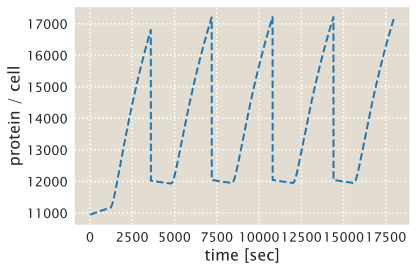

In [78]:
# Define color
colors = np.flip(sns.color_palette('Paired', n_colors=2), axis=0)

# Plot mean mRNA as solid line
plt.plot(df.time, p_mean, label=r'$\left\langle m \right\rangle$', 
         color=colors[0], linestyle='--')
# Plot +- standard deviation
# plt.fill_between(df.time, p_mean - np.sqrt(p_var), p_mean + np.sqrt(p_var),
#                  alpha=0.7, color=colors[1])

# # Group data frame by cell cycle
# df_group = df.groupby('cycle')
# # Loop through cycles
# for i, (group, data) in enumerate(df_group):
#     # Find index for two-promoter state
#     idx = data.state == 'double'
#     # Indicate states with two promoters
#     plt.plot(data.loc[idx, 'time'], 
#              np.array([(p_mean + np.sqrt(p_var)).max() + 2] * len(data))[idx],
#              color='g')

# Label plot
plt.xlabel('time [sec]')
plt.ylabel('protein / cell')

In [58]:
df.head()

,time,state,cycle,m0_P,m0_E,m1_P,m1_E,m2_P,m2_E,m3_P,...,mp_P,mp_E,p2_P,p2_E,m2p_P,m2p_E,mp2_P,mp2_E,p3_P,p3_E
0,0.000000,single,0,0.066367,0.933633,0.379915,3.549244,3.472075,27.017257,41.260213,...,25.277098,273.081369,238.961866,3274.071146,228.116636,2341.698210,2416.634303,27184.566990,25443.435038,347503.180919
1,1.201201,single,0,0.066367,0.933633,0.383348,3.597538,3.523695,27.557707,42.074029,...,26.195077,283.599611,252.528089,3462.335489,237.170647,2440.569447,2562.768005,28864.874227,27503.936198,375902.285270
2,2.402402,single,0,0.066367,0.933633,0.386758,3.645510,3.575266,28.098699,42.890654,...,27.129593,294.320726,266.599931,3657.679625,246.416036,2541.662207,2714.833091,30614.860034,29688.438066,406023.729693
3,3.603604,single,0,0.066367,0.933633,0.390146,3.693164,3.626784,28.640175,43.709991,...,28.080626,305.244656,281.186745,3860.235386,255.853073,2644.981098,2872.955930,32436.049840,32001.936458,437937.377794
4,4.804805,single,0,0.066367,0.933633,0.393511,3.740500,3.678246,29.182078,44.531943,...,29.048155,316.371315,296.297876,4070.134451,265.481993,2750.530270,3037.262995,34329.970794,34449.531569,471714.561889
